In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

In [2]:
initial_data = pd.read_csv('../Data/yelp_dataset_final.csv')

The goal of this model is to predict the Income Class of a zipcode, based on the distribution of "Yelp Dollar Signs" within that zipcode.

Let's first look at the distribution of Income Classes both in this dataset, and among all zipcodes as well.

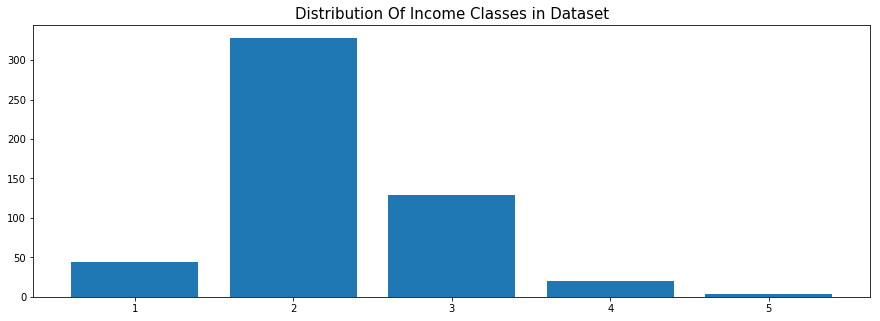

In [3]:
fig = plt.figure(figsize=(15,5))
grouped = initial_data.groupby('target')['target'].count()
plt.bar(grouped.index, grouped)
plt.title('Distribution Of Income Classes in Dataset',fontsize=15);

Importing IRS Data

In [4]:
IRS_zips = pd.read_csv('../Data/IRS_zipcodes_clean.csv')

Remaming columns, creating the income class (labeled 'Target') column for all IRS Zipcodes.

In [5]:
IRS_zips = IRS_zips.rename(columns={'zipcode':'zip',
                          '1':'income_level_1',
                          '2':'income_level_2',
                          '3':'income_level_3',
                          '4':'income_level_4',
                          '5':'income_level_5',
                          '6':'income_level_6'})

In [6]:
irs_freq_count = np.array(IRS_zips.loc[:, 'income_level_1':'income_level_6'])
cumm = np.cumsum(irs_freq_count, axis=1) 
indices = [np.searchsorted(row, row[-1]/2.0) for row in cumm]
IRS_zips['target'] = [i+1 for i in indices]

Now let's plot the distribution for all IRS Zipcodes

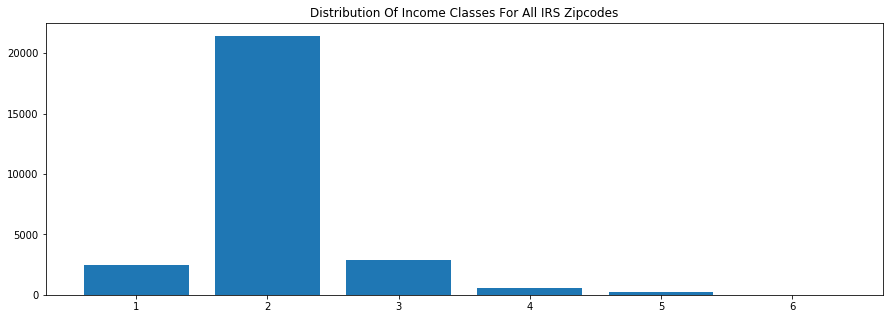

In [7]:
fig = plt.figure(figsize=(15,5))
grouped = IRS_zips.groupby('target')['target'].count()
plt.bar(grouped.index, grouped)
plt.title('Distribution Of Income Classes For All IRS Zipcodes',fontsize=12);

The Yelp Dataset seems to be separated into distinct geographic areas. Let's see if the income distributions are different for the distinct Metro Area.

In [8]:
def affluence_plotter(state,metro,font=None):
    
    df = initial_data.loc[initial_data['STATE'] == state]
    grouped = df.groupby('target')['target'].count()
    plt.bar(grouped.index, grouped)
    plt.title(f'{metro} Metro Area',fontsize=20)
    plt.ylabel('Zipcode Count',fontsize=16)
    plt.xlabel('Income Class',fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if font:
        plt.xticks(fontsize=font)
        plt.yticks(fontsize=font)

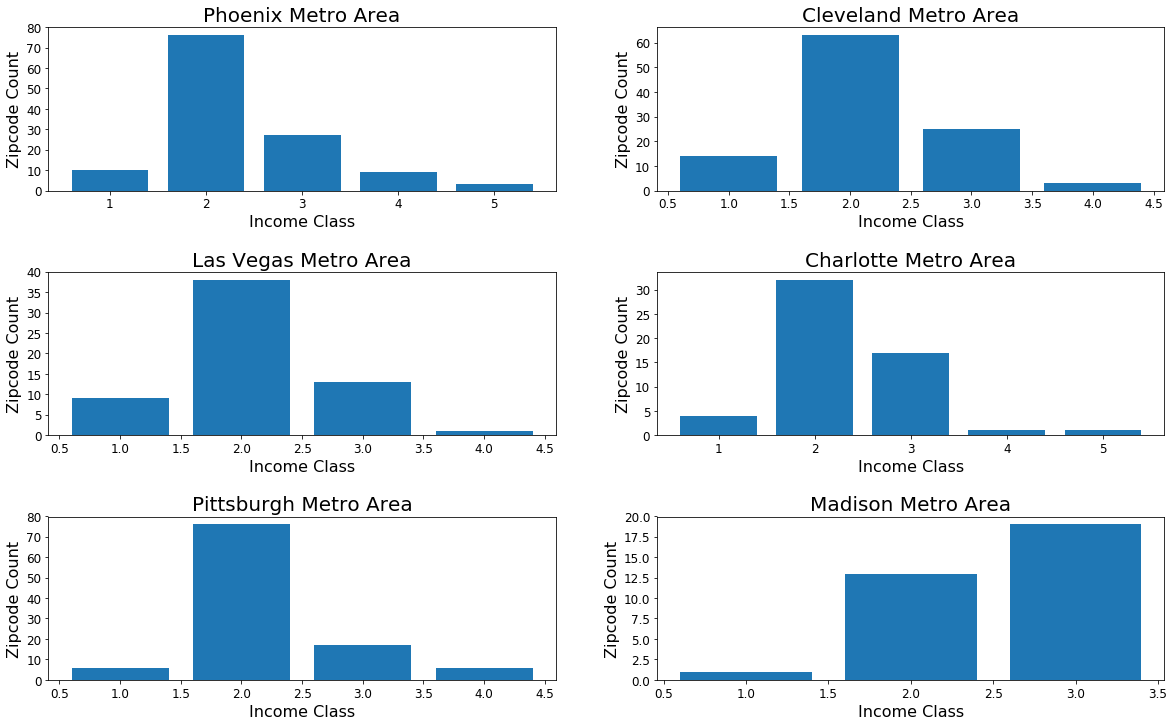

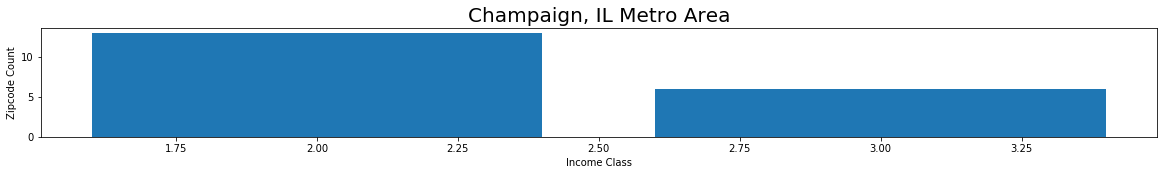

In [9]:
fig = plt.figure(figsize=(20,12))

plt.subplot(3, 2, 1)

affluence_plotter('AZ','Phoenix')
plt.subplot(3, 2, 2)
affluence_plotter('OH','Cleveland')
plt.subplot(3, 2, 3)
affluence_plotter('NV','Las Vegas')
plt.subplot(3, 2, 4)
affluence_plotter('NC','Charlotte')
plt.subplot(3, 2, 5)
affluence_plotter('PA','Pittsburgh')
plt.subplot(3, 2, 6)
affluence_plotter('WI','Madison')
plt.subplots_adjust(hspace=.5)
plt.show();

fig = plt.figure(figsize=(20,2))
illinois = initial_data.loc[initial_data['STATE'] == 'IL']
grouped = illinois.groupby('target')['target'].count()
plt.title('Champaign, IL Metro Area',fontsize=20)
plt.bar(grouped.index, grouped)
plt.xlabel('Income Class');
plt.ylabel('Zipcode Count');

Looks like most metro areas have more of income class "2", than any other class. This is consistent with both the Yelp Open Dataset, as well as with the National IRS Dataset.

### Yelp Dollar Signs By Metro Area

In [10]:
def yelp_by_state(state):
    grouped = initial_data.groupby('STATE')[[col for col in initial_data.columns if 'yelp_dollar_' in col]].sum()
    objects = list(grouped.loc[state].keys())
    y_pos = np.arange(len(objects))
    performance = grouped.loc[state].values
     
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Business Count')
    plt.title(f'Yelp Dollar Signs By State ({state})')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

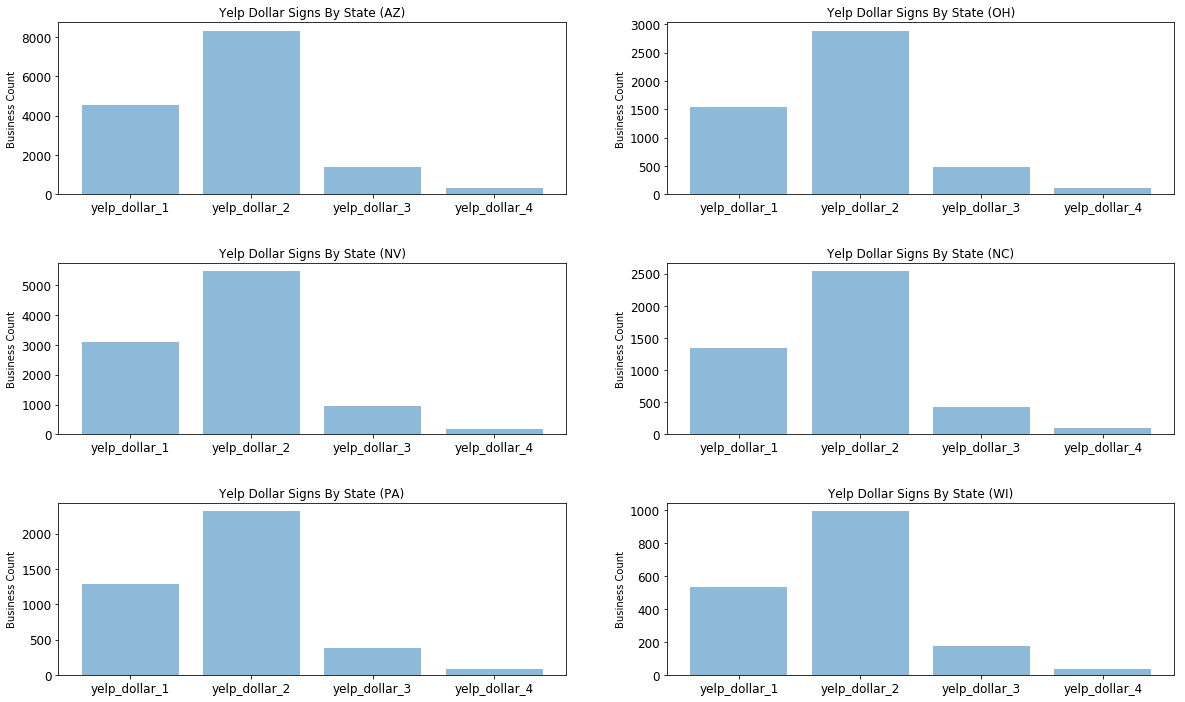

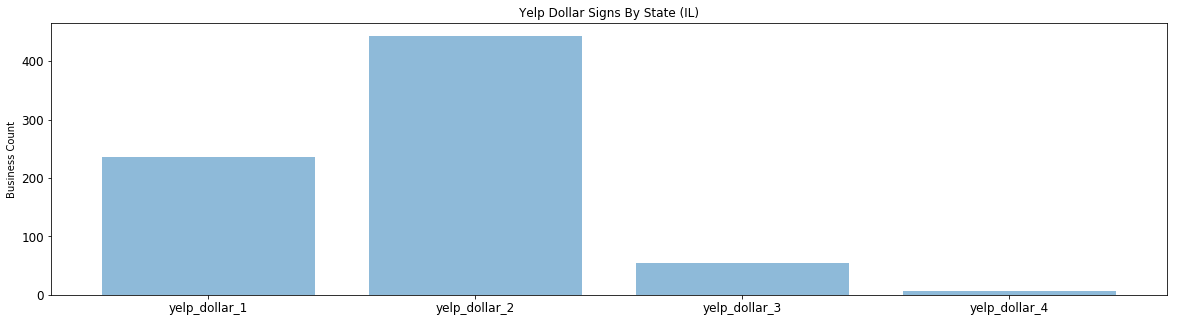

In [11]:
fig = plt.figure(figsize=(20,12))
plt.subplot(3, 2, 1)
yelp_by_state('AZ')

plt.subplot(3, 2, 2)
yelp_by_state('OH')

plt.subplot(3, 2, 3)
yelp_by_state('NV')

plt.subplot(3, 2, 4)
yelp_by_state('NC')

plt.subplot(3, 2, 5)
yelp_by_state('PA')

plt.subplot(3, 2, 6)
yelp_by_state('WI')

plt.subplots_adjust(hspace=.4)

plt.show()

fig = plt.figure(figsize=(20,5))
yelp_by_state('IL')

Looks like there are very similar trends for each metro area.

### Plotting Maps

In [36]:
a_map = folium.Map([36.1699, -115.1398], zoom_start=9)

The ShapeFile is very large, but it can be downloaded here: https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html

Download the zip, and put the file 'cb_2017_us_zcta510_500k.shp' in your desired folder

In [24]:
census_zips_bounds = gpd.read_file('/Volumes/data/cb_2017_us_zcta510_500k/cb_2017_us_zcta510_500k.shp')

In [25]:
census_zips_bounds = census_zips_bounds[['ZCTA5CE10','geometry']]
census_zips_bounds.columns = ['zip','geometry']
census_zips_bounds.crs = {'init' :'epsg:4326'}
census_zips_bounds['zip'] = census_zips_bounds['zip'].astype(int)

In [26]:
nevada_zips = initial_data.loc[initial_data['STATE'] == 'NV']['zip'].unique()

In [27]:
nevadazipbounds = census_zips_bounds.loc[census_zips_bounds['zip'].isin(nevada_zips)]

In [28]:
def chloroplether(zips,stat,name_of_stat):
    
    the_geo_data = census_zips_bounds[census_zips_bounds['zip'].isin(zips)].reset_index(drop=True)
    the_geo_data = the_geo_data.merge(initial_data[['zip',stat]], on='zip')
    the_geo_data.columns = ['regionid','geometry','stat']
    the_data = pd.DataFrame(the_geo_data[['regionid','stat']])
    
    chloropleth = folium.Choropleth(
    geo_data=the_geo_data,
    data=the_data,
    columns=['regionid', 'stat'],
    key_on='feature.properties.regionid',
    fill_color='YlGnBu',
    highlight=True,
    name=f'{name_of_stat}'
    )
    
    return chloropleth

In [37]:
chloroplether(nevada_zips,'target','Target Income Class').add_to(a_map)

In [38]:
mc = MarkerCluster(name='Markers')

In [39]:
for index, row in nevadazipbounds.iterrows():
    zipcode = row['zip']
    folium.Marker([row['geometry'].centroid.y, row['geometry'].centroid.x], popup=f"{zipcode}").add_to(mc)

In [40]:
mc.add_to(a_map)

In [42]:
a_map.add_child(folium.LayerControl())

In [43]:
map_2 = folium.Map([36.1699, -115.1398], zoom_start=9)

In [44]:
folium.GeoJson(
    nevadazipbounds,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.3,
    }
).add_to(map_2)

In [45]:
yelp_with_dollars = pd.read_csv('../Data/Yelp_Clean.csv')

In [46]:
def point_plotter(specific_zips,the_map):
    specific_frame = yelp_with_dollars[yelp_with_dollars['zip'].isin(specific_zips)]
    specific_frame.reset_index(drop=True,inplace=True)
    
    specific_frame1 = specific_frame.loc[specific_frame['dollar_sign'] == 1]
    specific_frame2 = specific_frame.loc[specific_frame['dollar_sign'] == 2]
    specific_frame3 = specific_frame.loc[specific_frame['dollar_sign'] == 3]
    specific_frame4 = specific_frame.loc[specific_frame['dollar_sign'] == 4]
    
    name1 = list(specific_frame1["name"])
    lat1 = list(specific_frame1["latitude"])
    lon1 = list(specific_frame1["longitude"])

    name2 = list(specific_frame2["name"])
    lat2 = list(specific_frame2["latitude"])
    lon2 = list(specific_frame2["longitude"])

    name3 = list(specific_frame3["name"])
    lat3 = list(specific_frame3["latitude"])
    lon3 = list(specific_frame3["longitude"])

    name4 = list(specific_frame4["name"])
    lat4 = list(specific_frame4["latitude"])
    lon4 = list(specific_frame4["longitude"])
    
    fg1 = folium.FeatureGroup(name="1 Dollar Sign")
    fg2 = folium.FeatureGroup(name="2 Dollar Signs")
    fg3 = folium.FeatureGroup(name="3 Dollar Signs")
    fg4 = folium.FeatureGroup(name="4 Dollar Signs")
    
    for lt, ln, nm in zip(lat1, lon1, name1):
        fg1.add_child(folium.CircleMarker(location=[lt, ln], radius = 1, popup= nm + ", " + str(1)+" price",
        fill_color='red', fill=True,  color = 'red', fill_opacity=0.7))

    for lt, ln, nm in zip(lat2, lon2, name2):
        fg2.add_child(folium.CircleMarker(location=[lt, ln], radius = 1, popup= nm + ", " + str(2)+" price",
        fill_color='orange', fill=True,  color = 'orange', fill_opacity=0.7))

    for lt, ln, nm in zip(lat3, lon3, name3):
        fg3.add_child(folium.CircleMarker(location=[lt, ln], radius = 1, popup= nm + ", " + str(3)+" price",
        fill_color='yellow', fill=True,  color = 'yellow', fill_opacity=0.7))

    for lt, ln, nm in zip(lat4, lon4, name4):
        fg4.add_child(folium.CircleMarker(location=[lt, ln], radius = 1, popup= nm + ", " + str(4)+" price",
        fill_color='green', fill=True,  color = 'green', fill_opacity=0.7))
        
    the_map.add_child(fg1)
    the_map.add_child(fg2)
    the_map.add_child(fg3)
    the_map.add_child(fg4)
    the_map.add_child(folium.LayerControl())

In [49]:
point_plotter(nevada_zips[:5],map_2)

In [50]:
map_2

Engineer some different Affluence/Yelp interaction terms and look at potential correlation

In [51]:
initial_data['total_returns'] = initial_data[['income_level_1','income_level_2','income_level_3',
                                             'income_level_4', 'income_level_5','income_level_6']].sum(axis=1)

In [52]:
initial_data['perc_of_six'] = initial_data['income_level_6'] / initial_data['total_returns']
initial_data['perc_of_five'] = initial_data['income_level_5'] / initial_data['total_returns']
initial_data['perc_of_four'] = initial_data['income_level_4'] / initial_data['total_returns']
initial_data['perc_of_three'] = initial_data['income_level_3'] / initial_data['total_returns']
initial_data['perc_of_two'] = initial_data['income_level_2'] / initial_data['total_returns']
initial_data['perc_of_one'] = initial_data['income_level_1'] / initial_data['total_returns']

In [53]:
initial_data['perc_of_yelp1'] = initial_data['yelp_dollar_1'] / initial_data['Total_Business']
initial_data['perc_of_yelp2'] = initial_data['yelp_dollar_2'] / initial_data['Total_Business']
initial_data['perc_of_yelp3'] = initial_data['yelp_dollar_3'] / initial_data['Total_Business']
initial_data['perc_of_yelp4'] = initial_data['yelp_dollar_4'] / initial_data['Total_Business']

In [54]:
initial_data['yelp_dollar_1_weighted'] = initial_data['yelp_dollar_1'] + 5

In [55]:
initial_data['yelp_dollar_2_weighted'] = initial_data['yelp_dollar_2'] + 5
initial_data['yelp_dollar_3_weighted'] = initial_data['yelp_dollar_3'] + 5
initial_data['yelp_dollar_4_weighted'] = initial_data['yelp_dollar_4'] + 5

In [56]:
initial_data['perc_of_yelp1_weighted'] = initial_data['yelp_dollar_1_weighted'] / initial_data['Total_Business']
initial_data['perc_of_yelp2_weighted'] = initial_data['yelp_dollar_2_weighted'] / initial_data['Total_Business']
initial_data['perc_of_yelp3_weighted'] = initial_data['yelp_dollar_3_weighted'] / initial_data['Total_Business']
initial_data['perc_of_yelp4_weighted'] = initial_data['yelp_dollar_4_weighted'] / initial_data['Total_Business']

In [57]:
initial_data['income_level_1_weighted'] = initial_data['income_level_1'] + 5
initial_data['income_level_2_weighted'] = initial_data['income_level_2'] + 5
initial_data['income_level_3_weighted'] = initial_data['income_level_3'] + 5
initial_data['income_level_4_weighted'] = initial_data['income_level_4'] + 5
initial_data['income_level_5_weighted'] = initial_data['income_level_5'] + 5
initial_data['income_level_6_weighted'] = initial_data['income_level_6'] + 5

In [58]:
initial_data['weighted_returns'] = initial_data[['income_level_1_weighted','income_level_2_weighted','income_level_3_weighted',
                                             'income_level_4_weighted', 'income_level_5_weighted','income_level_6_weighted']].sum(axis=1)

In [59]:
initial_data['perc_of_six_weighted'] = initial_data['income_level_6_weighted'] / initial_data['weighted_returns']
initial_data['perc_of_five_weighted'] = initial_data['income_level_5_weighted'] / initial_data['weighted_returns']
initial_data['perc_of_four_weighted'] = initial_data['income_level_4_weighted'] / initial_data['weighted_returns']
initial_data['perc_of_three_weighted'] = initial_data['income_level_3_weighted'] / initial_data['weighted_returns']
initial_data['perc_of_two_weighted'] = initial_data['income_level_2_weighted'] / initial_data['weighted_returns']
initial_data['perc_of_one_weighted'] = initial_data['income_level_1_weighted'] / initial_data['weighted_returns']

In [60]:
initial_data['total_aff'] = (initial_data['perc_of_one_weighted']) + (initial_data['perc_of_two_weighted'] * 2) + (initial_data['perc_of_three_weighted'] * 3) + (initial_data['perc_of_four_weighted'] * 4) + (initial_data['perc_of_five_weighted'] * 5) + (initial_data['perc_of_six_weighted'] * 6)

In [61]:
initial_data.sort_values('total_aff',ascending=False).head()

,Index,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,...,income_level_5_weighted,income_level_6_weighted,weighted_returns,perc_of_six_weighted,perc_of_five_weighted,perc_of_four_weighted,perc_of_three_weighted,perc_of_two_weighted,perc_of_one_weighted,total_aff
406,406,85262,3,7,1,0,11,AZ,900.0,560.0,...,1345.0,1665.0,5410.0,0.307763,0.248614,0.084104,0.087800,0.104436,0.167283,4.065619
143,143,28207,9,13,0,1,23,NC,840.0,540.0,...,545.0,1775.0,4390.0,0.404328,0.124146,0.067198,0.087699,0.124146,0.192483,4.019362
398,398,85253,44,80,16,7,147,AZ,1690.0,940.0,...,1115.0,3155.0,8110.0,0.389026,0.137485,0.063502,0.084464,0.116523,0.209001,3.971023
408,408,85266,12,23,2,1,38,AZ,1010.0,530.0,...,1285.0,1355.0,5080.0,0.266732,0.252953,0.085630,0.089567,0.105315,0.199803,3.886811
181,181,44040,3,2,0,0,5,OH,360.0,180.0,...,335.0,495.0,1710.0,0.289474,0.195906,0.102339,0.090643,0.108187,0.213450,3.827485


In [62]:
initial_data.sort_values('perc_of_six',ascending=False).head()

,Index,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,...,income_level_5_weighted,income_level_6_weighted,weighted_returns,perc_of_six_weighted,perc_of_five_weighted,perc_of_four_weighted,perc_of_three_weighted,perc_of_two_weighted,perc_of_one_weighted,total_aff
143,143,28207,9,13,0,1,23,NC,840.0,540.0,...,545.0,1775.0,4390.0,0.404328,0.124146,0.067198,0.087699,0.124146,0.192483,4.019362
398,398,85253,44,80,16,7,147,AZ,1690.0,940.0,...,1115.0,3155.0,8110.0,0.389026,0.137485,0.063502,0.084464,0.116523,0.209001,3.971023
406,406,85262,3,7,1,0,11,AZ,900.0,560.0,...,1345.0,1665.0,5410.0,0.307763,0.248614,0.084104,0.087800,0.104436,0.167283,4.065619
181,181,44040,3,2,0,0,5,OH,360.0,180.0,...,335.0,495.0,1710.0,0.289474,0.195906,0.102339,0.090643,0.108187,0.213450,3.827485
48,48,15142,0,1,0,0,1,PA,200.0,170.0,...,195.0,315.0,1130.0,0.278761,0.172566,0.092920,0.119469,0.154867,0.181416,3.756637


In [63]:
initial_data.sort_values('target',ascending=False).head()

,Index,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,...,income_level_5_weighted,income_level_6_weighted,weighted_returns,perc_of_six_weighted,perc_of_five_weighted,perc_of_four_weighted,perc_of_three_weighted,perc_of_two_weighted,perc_of_one_weighted,total_aff
143,143,28207,9,13,0,1,23,NC,840.0,540.0,...,545.0,1775.0,4390.0,0.404328,0.124146,0.067198,0.087699,0.124146,0.192483,4.019362
406,406,85262,3,7,1,0,11,AZ,900.0,560.0,...,1345.0,1665.0,5410.0,0.307763,0.248614,0.084104,0.087800,0.104436,0.167283,4.065619
398,398,85253,44,80,16,7,147,AZ,1690.0,940.0,...,1115.0,3155.0,8110.0,0.389026,0.137485,0.063502,0.084464,0.116523,0.209001,3.971023
408,408,85266,12,23,2,1,38,AZ,1010.0,530.0,...,1285.0,1355.0,5080.0,0.266732,0.252953,0.085630,0.089567,0.105315,0.199803,3.886811
117,117,28036,10,17,2,3,32,NC,1930.0,1130.0,...,1895.0,1475.0,8090.0,0.182324,0.234240,0.093325,0.110630,0.140297,0.239184,3.490111


Looks like the same zipcodes keep coming up for the new affluence metrics (compared to the target), so they are likely highly co-linear.

## Total Dataset Heatmap

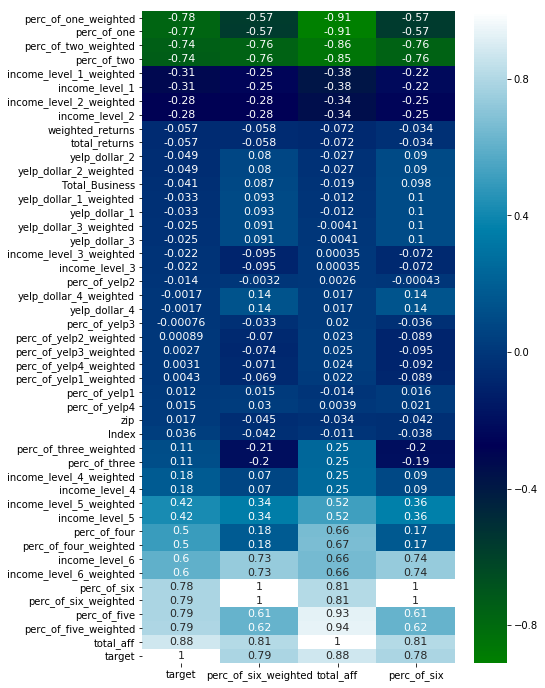

In [65]:
plt.figure(figsize = (7,12))
#mask = np.triu(np.ones_like(initial_data.select_dtypes(['float64', 'int64']).corr()))
sns.heatmap(initial_data.corr()[['target','perc_of_six_weighted','total_aff','perc_of_six']].sort_values('target'),
            annot=True,annot_kws={"size":11}, cmap='ocean',)

Text(0.5, 1.0, 'Correlation Between Affluence and \n Yelp Variables For Entire Dataset')

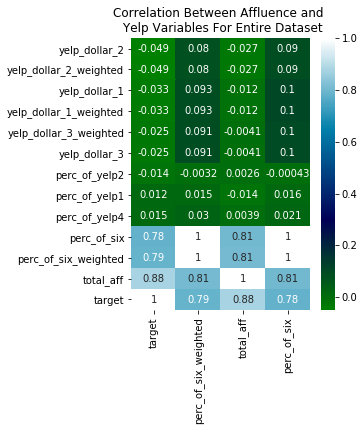

In [66]:
specific_corr = pd.DataFrame((initial_data.corr().abs()>.005)['target'].sort_values(ascending=False))
target_corr_cols = specific_corr.loc[specific_corr['target'] == 1].index.tolist()
target_corr_cols = [col for col in target_corr_cols if 'yelp' in col]
target_corr_cols.append('target')
target_corr_cols.append('total_aff')
target_corr_cols.append('perc_of_six')
target_corr_cols.append('perc_of_six_weighted')
sale_corrs = initial_data[target_corr_cols].corr()[['target','perc_of_six_weighted','total_aff','perc_of_six']]
plt.figure(figsize = (4,5))

ax = sns.heatmap(sale_corrs.sort_values('target', ascending=True),annot=True,cmap='ocean')
ax.set_title('Correlation Between Affluence and \n Yelp Variables For Entire Dataset')

In [67]:
def heatmapper(state,metro):
    df = initial_data.loc[initial_data['STATE'] == state]
    specific_corr = pd.DataFrame((df.corr().abs()>.005)['target'].sort_values(ascending=False))
    target_corr_cols = specific_corr.loc[specific_corr['target'] == 1].index.tolist()
    target_corr_cols = [col for col in target_corr_cols if 'yelp' in col]
    target_corr_cols.append('target')
    target_corr_cols.append('total_aff')
    target_corr_cols.append('perc_of_six')
    target_corr_cols.append('perc_of_six_weighted')
    sale_corrs = initial_data[target_corr_cols].corr()[['target','perc_of_six_weighted','total_aff','perc_of_six']]
    ax = sns.heatmap(sale_corrs.sort_values('target', ascending=True),annot=True,cmap='ocean')
    ax.set_title(f'Correlation Between Affluence and \n Yelp Variables For {metro}')

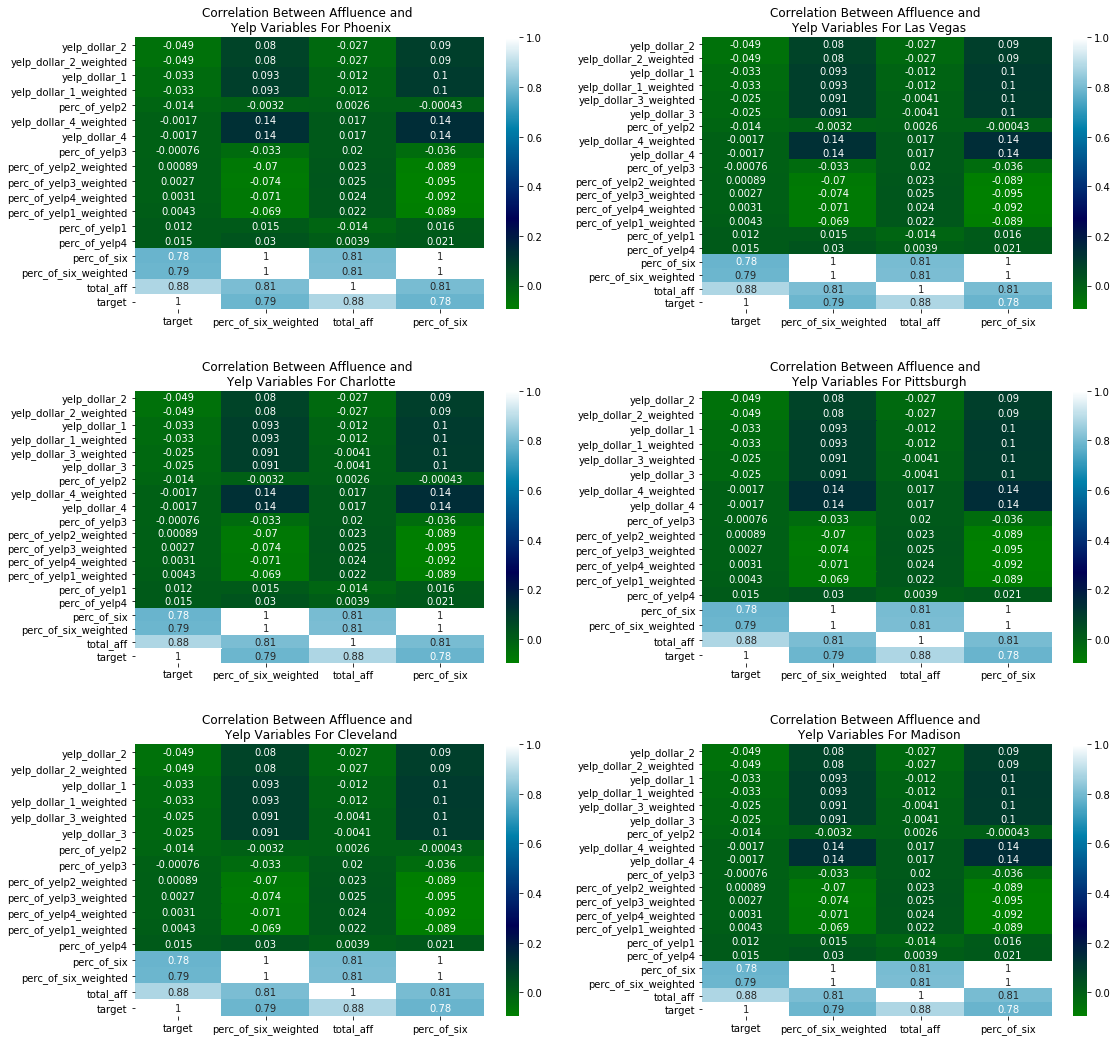

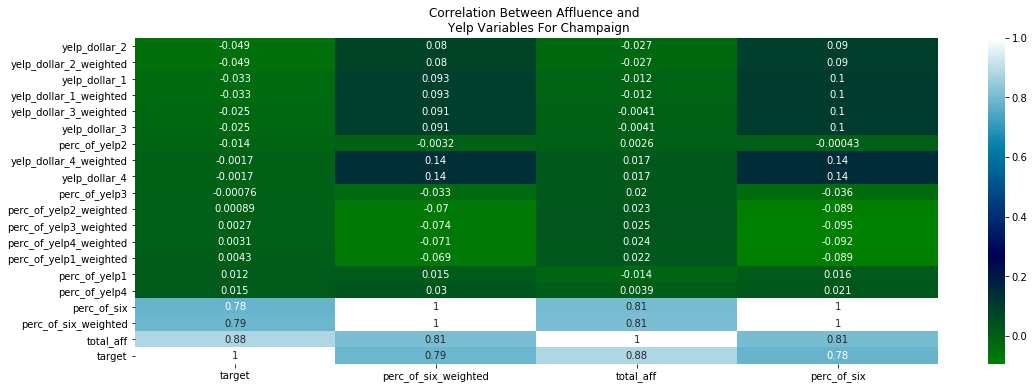

In [68]:
fig = plt.figure(figsize=(18,18))

plt.subplot(3, 2, 1)
heatmapper('AZ','Phoenix')
plt.subplot(3, 2, 2)
heatmapper('NV','Las Vegas')
plt.subplot(3, 2, 3)
heatmapper('NC','Charlotte')
plt.subplot(3, 2, 4)
heatmapper('PA','Pittsburgh')
plt.subplot(3, 2, 5)
heatmapper('OH','Cleveland')
plt.subplot(3, 2, 6)
heatmapper('WI','Madison')

plt.subplots_adjust(hspace=.3)
plt.subplots_adjust(wspace=.3)

plt.figure(figsize = (18,6))
heatmapper('IL','Champaign')